In [1]:
from pathlib import Path

# Get the current working directory as a Path object
current_path = Path.cwd()
home_folder = 'evan_home'

# Traverse up the directory tree until you find the target folder
for parent in [current_path] + list(current_path.parents):
    if parent.name == home_folder:
        home_path = parent
        break
else:
    raise ValueError(f"Folder '{home_folder}' not found in the current working directory.")

print("Home Path:", home_path)
source_code_dir = home_path / 'Source_code'
dataset_dir = home_path / 'Dataset'


Home Path: c:\Users\evanlee\Documents\Bmi_NAS_evan\evan_home


In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import scanpy as sc
import scvi
import seaborn as sns
from scvi.external import CellAssign

c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read dataset (as Normalized and log1p)

In [3]:
# bmcite = sc.read_h5ad(r"C:\Users\evanlee\Documents\Research_datasets\Stuart_bm\Stuart_bmcite_RNAassay_original.h5ad")
bmcite = sc.read_h5ad(dataset_dir / 'Stuart_bm/Stuart_bmcite_RNAassay_original.h5ad')
label = bmcite.obs['celltype.l1'].tolist()
types = np.unique(label).tolist()
print('all cell types:', types)
print(bmcite.shape)

all cell types: ['B cell', 'Mono/DC', 'NK', 'Progenitor cells', 'T cell']
(30672, 17009)


In [40]:
bmcite.obs.head()

,nCount_RNA,nFeature_RNA,nCount_ADT,nFeature_ADT,lane,donor,celltype.l1,celltype.l2,RNA.weight
a_AAACCTGAGCTTATCG-1,7546.0,2136,1350.0,25,HumanHTO4,batch1,Progenitor cells,Prog_RBC,0.482701
a_AAACCTGAGGTGGGTT-1,1029.0,437,2970.0,25,HumanHTO1,batch1,T cell,gdT,0.241789
a_AAACCTGAGTACATGA-1,1111.0,429,2474.0,23,HumanHTO5,batch1,T cell,CD4 Naive,0.507714
a_AAACCTGCAAACCTAC-1,2741.0,851,4799.0,25,HumanHTO3,batch1,T cell,CD4 Memory,0.431308
a_AAACCTGCAAGGTGTG-1,2099.0,843,5434.0,25,HumanHTO2,batch1,Mono/DC,CD14 Mono,0.568508


## Count number of PreLect features

In [4]:
import os
# os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch_noZ\Level1\feature_selection_k3")
# os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_batch_noZ/Level1/feature_selection_k3')
os.chdir(source_code_dir / 'PBMC_Hao_batch_noZ/Level1/feature_selection_k3')

features_dict = {}
hao_l1 = ['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T']
# Read features for each celltype
for celltype in hao_l1:
    try:
        feature_df = pd.read_csv(f'{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
        features_dict[celltype] = feature_df
    except:
        print('skipping:', celltype)
        continue

In [5]:
count_df = pd.DataFrame(columns=['Feature_count', 'Positive_feature_count'])
for celltype in features_dict.keys():
    feature_df = features_dict[celltype]
    feature_count = feature_df.shape[0]
    positive_count = feature_df[feature_df['Tendency'] == 1].shape[0]
    count_df.loc[celltype] = [feature_count, positive_count]

median_feature_no = int(np.ceil(np.median(count_df['Feature_count'])))
mean_feature_no = int(np.ceil(np.mean(count_df['Feature_count'])))
print('Median feature number:', median_feature_no)
print('Mean feature number:', mean_feature_no)
count_df

Median feature number: 42
Mean feature number: 79


,Feature_count,Positive_feature_count
B,19,10
CD4_T,201,95
CD8_T,23,9
DC,50,23
Mono,50,20
NK,33,17
other,5,3
other_T,247,112


## Find top DEGs

In [43]:
# Find marker genes
def rank_genes(adata, all_types, n_genes):
    sc.tl.rank_genes_groups(adata, groupby='celltype.l1', n_genes=n_genes, method='wilcoxon')

    # Get the top ranked genes for each celltype
    genes_dict = {}

    for celltype in all_types:
        genes_df = sc.get.rank_genes_groups_df(adata, group=celltype)
        genes = genes_df['names'].tolist()
        genes_dict[celltype] = genes
    
    return genes_dict
    

In [44]:
print('Median feature number:', median_feature_no)
DE_genes_dict = rank_genes(bmcite, types, n_genes=median_feature_no)
DE_genes_dict.keys()

Median feature number: 42


c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


dict_keys(['B cell', 'Mono/DC', 'NK', 'Progenitor cells', 'T cell'])

In [45]:
unique_genes = set()
for gene_list in DE_genes_dict.values():
    unique_genes.update(gene_list)
len(unique_genes)

202

In [46]:
# Create a new dataframe with genes as indexes and cell types as columns
marker_gene_mat = pd.DataFrame(0, index=list(unique_genes), columns=types)

# Iterate through the DEGs and update the new dataframe with 1 where there is a relationship
for celltype, gene_list in DE_genes_dict.items():
    for g in gene_list:
        marker_gene_mat.loc[g, celltype] = 1
marker_gene_mat


,B cell,Mono/DC,NK,Progenitor cells,T cell
RPS25,0,0,0,0,1
MARCH1,1,0,0,0,0
TRBC2,0,0,0,0,1
H3F3B,0,0,1,0,0
SH3BGRL3,0,1,0,0,0
...,...,...,...,...,...
TNFRSF13C,1,0,0,0,0
HMGB2,0,0,0,1,0
IFITM2,0,0,1,0,0
B2M,0,0,1,0,0


## Turn dataset back to raw counts
CellAssign takes raw counts matrix

In [47]:
# Take raw counts from layers['counts']
bmcite.X = bmcite.layers['counts']

In [48]:
# Briefly view adata.X
rows, cols = bmcite.X[:5,:].nonzero()
i = 0
for row, col in zip(rows, cols):
    if i == 20: break
    print(f'Row {row}, Column {col}, Value {bmcite.X[row, col]}')
    i += 1


Row 0, Column 23, Value 1.0
Row 0, Column 31, Value 1.0
Row 0, Column 49, Value 1.0
Row 0, Column 50, Value 1.0
Row 0, Column 58, Value 1.0
Row 0, Column 59, Value 2.0
Row 0, Column 75, Value 1.0
Row 0, Column 77, Value 1.0
Row 0, Column 78, Value 1.0
Row 0, Column 84, Value 19.0
Row 0, Column 88, Value 1.0
Row 0, Column 94, Value 1.0
Row 0, Column 101, Value 1.0
Row 0, Column 106, Value 1.0
Row 0, Column 108, Value 1.0
Row 0, Column 110, Value 7.0
Row 0, Column 136, Value 1.0
Row 0, Column 138, Value 2.0
Row 0, Column 147, Value 1.0
Row 0, Column 162, Value 1.0


In [49]:
# Set up size factor
lib_size = bmcite.X.sum(1)
bmcite.obs["size_factor"] = lib_size / np.mean(lib_size)

## Subset dataset to only the marker genes

In [50]:
# It is critical that gene expression data containing only marker genes is used as input to cellassign.
a = bmcite.var_names
b = marker_gene_mat.index
inter = a.intersection(b)
print('Intersection:', len(inter))
common_genes = [i in b for i in a]  # a list of bools
bmcite_subset = bmcite[:, common_genes].copy()  # only select common_genes columns
print(bmcite_subset.shape)

Intersection: 202
(30672, 202)


In [51]:
# Sets up the AnnData object for this model.
scvi.external.CellAssign.setup_anndata(bmcite_subset, size_factor_key="size_factor")

c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scvi\data\fields\_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


In [52]:
# Train CellAssign
import torch
torch.set_float32_matmul_precision('high')
model = CellAssign(bmcite_subset, marker_gene_mat)
model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Epoch 261/400:  65%|██████▌   | 261/400 [04:22<02:19,  1.00s/it, v_num=1, train_loss_step=353, train_loss_epoch=350]
Monitored metric elbo_validation did not improve in the last 15 records. Best score: 348.334. Signaling Trainer to stop.


<Axes: xlabel='epoch'>

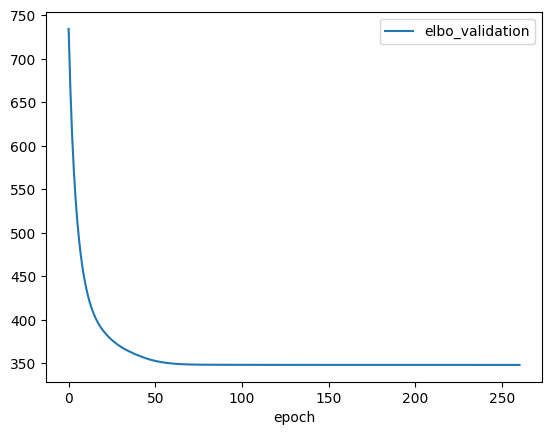

In [53]:
model.history["elbo_validation"].plot()

In [54]:
predictions = model.predict()

In [ ]:
# os.chdir(r'C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\Stuart_bm_annotate\Stuart_CellAssign\with_DEG')
os.chdir(source_code_dir / 'Stuart_bm_annotate/Stuart_CellAssign/with_DEG')
predictions.index = bmcite.obs_names
predictions.to_csv('CellAssign_DEGmedian_pred_Stuart_L1.csv')

In [56]:
largest_values = []
largest_columns = []
assignments = []
for index, row in predictions.iterrows():
    # find largest value and their corresponding columns
    largest_value = row.max()
    largest_column = row.idxmax()
    largest_values.append(largest_value)
    largest_columns.append(largest_column)

    assign = largest_column
    assignments.append(assign)

result_df = pd.DataFrame({'Largest Value': largest_values, 'Largest Column': largest_columns, 'Assignment': assignments})
for celltype in types:
    print(celltype, '\t', sum(result_df['Assignment'] == celltype))


B cell 	 3798
Mono/DC 	 8241
NK 	 3952
Progenitor cells 	 1942
T cell 	 12739
